# ADA - Unsupervised learning

In [1]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Part A) Tutorial

In this tutorial, you will learn how to discover clusters in data using Python.

Let's start by creating some **[synthetic](https://en.wikipedia.org/wiki/Synthetic_data)** data!
First, we create a super secret number that represents the number of the cluster to generate. 

Don't print it! We'll try to discover it automatically.

## K-Means

In [2]:
random.seed(42)
top_secret_number = random.randint(2, 10)

Now we can generate some data distributed in n groups:

In [3]:
total_samples = 100

# This create some artifical clusters with standard dev. = 2
X, _, centers = make_blobs(n_samples=total_samples, 
                           centers=top_secret_number, 
                           cluster_std=2,
                           n_features=2,
                           return_centers=True, 
                           random_state=42)

X[:3]

array([[-8.57321463, -9.90980404],
       [ 6.26691327, -0.48855895],
       [-3.44814639, 10.09940622]])

Let's see how these clusters look like and where is their center:

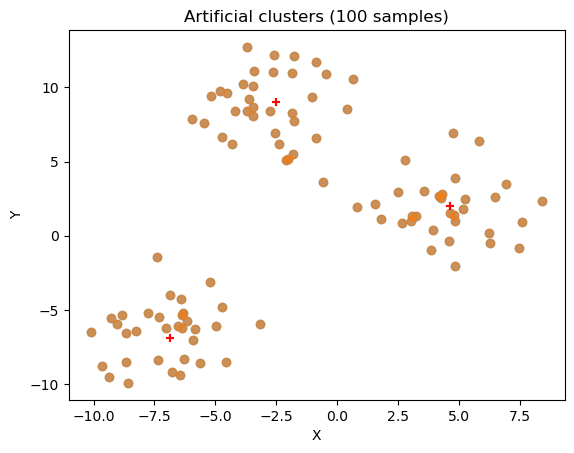

In [5]:
plt.scatter(X[:,0], X[:,1], alpha=0.6)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Artificial clusters (%s samples)" % total_samples)

for c in centers:
    plt.scatter(c[0], c[1], marker="+", color="red")
plt.show()

### Clustering the data
How many clusters do you see? Probably easy for a human, but not so trivial for a computer. 

Let's try to group the data with K-Means. Recall that K-Means requires you to specify the number of clusters (K). Let's start by testing multiple values between 2 and 10:

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

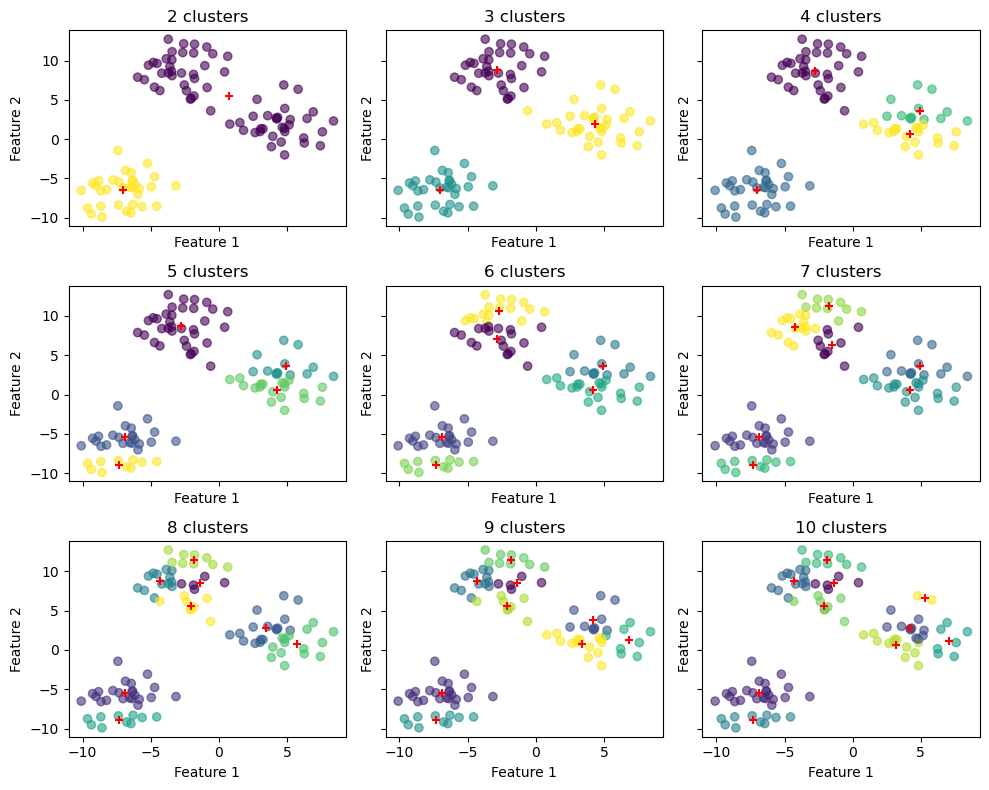

In [6]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 10

# Compute number of row and columns
COLUMNS = 3
ROWS = math.ceil((MAX_CLUSTERS-MIN_CLUSTERS)/COLUMNS)
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)

# Plot the clusters
for n_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    current_column = (n_clusters-MIN_CLUSTERS)%COLUMNS
    current_row = (n_clusters-MIN_CLUSTERS)//COLUMNS
    # Get the axis where to add the plot
    ax = axs[current_row, current_column]
    # Cluster the data with the current number of clusters
    kmean = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    # Plot the data by using the labels as color
    ax.scatter(X[:,0], X[:,1], c=kmean.labels_, alpha=0.6)
    ax.set_title("%s clusters"%n_clusters)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    # Plot the centroids
    for c in kmean.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()
plt.show()

### Bonus example: 
Did you know you can animate your plots?

In [ ]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()


X_3clusters, _, centers = make_blobs(n_samples=100, 
                           centers=3, 
                           cluster_std=2,
                           return_centers=True, 
                           random_state=99)

# Update frame callback 
def update(max_iter):
    # Clean the plot
    plt.clf()
    plt.cla()
    # Cluster and get the labels
    kmeans = KMeans(n_clusters=3, 
                    init="random", 
                    algorithm="lloyd",
                    random_state=10, 
                    n_init=1, max_iter=max_iter).fit(X_3clusters)
    # Plot
    plt.scatter(X_3clusters[:,0], X_3clusters[:,1], c=kmeans.labels_, alpha=0.6)
    for c in kmeans.cluster_centers_:
        plt.scatter(c[0], c[1], marker="+", color="red")
    plt.title("%s iterations" % max_iter)

# Animate 1 frame per second
anim = FuncAnimation(fig, update, frames=np.arange(1, 20), interval=500)

# Save the gif
anim.save('clusters.gif', dpi=80)

MovieWriter ffmpeg unavailable; using Pillow instead.


c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

### How to select K in K-Means?

You have a couple of options:
- Silhouette score: Find the K with the desired tradeoff between the number of clusters and cohesion/separation.
- Elbow method: Find the "elbow" in the curve of the Sum of Squared Errors

Let's see what we can observe using these 2 methods.

#### Silhouette score

To generate the curve of the silhouette score, we cluster the data with different value of K and plot the resulting values.

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

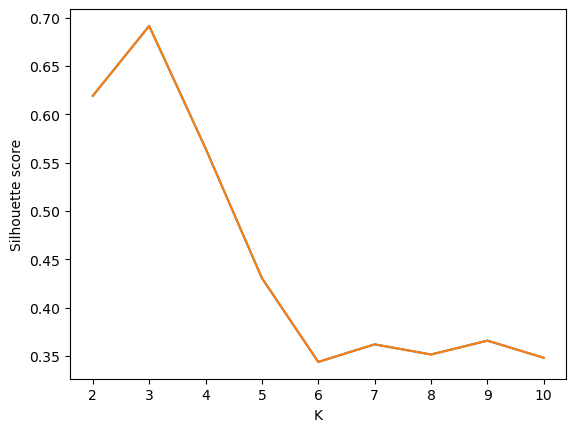

In [10]:
silhouettes = []

# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(X)
    # Get the Silhouette score
    score = silhouette_score(X, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
plt.show()


#### Elbow method

Similarly to the previous case, we compute the SSE for different values of K, and we plot the distribution:

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

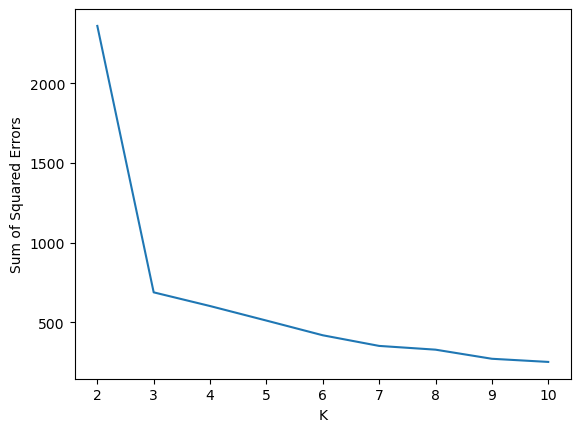

In [11]:
def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    plt.show()
    
plot_sse(X)

In this case, we get the same recommendation from both methods: K=3. Silhouette suggests that using 3 clusters is a fair tradeoff between the number of groups and their separation. The elbow method shows how the SSE reduction is less significant with more than 3 clusters.

Let's plot the best clusters:

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


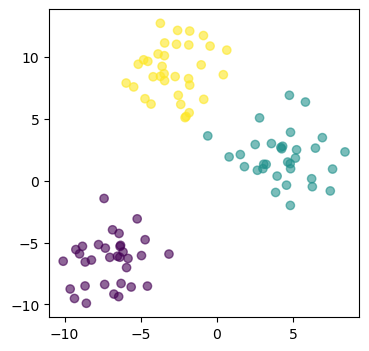

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(4,4), sharey=True)

# Plot the clusters with K = 3
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X)
axs.scatter(X[:,0], X[:,1], c=labels, alpha=0.6)
plt.show()


Ultimately it is up to you (domain expert!) to pick the number of clusters that better represent the data.

The best representation, in this case, is obtained with k = 3.

-----

### Visualizing high dimensional data

Visualizing 2-dimensional data is easy, but what happens when we have more than three features? 

We can use dimensionality reduction techniques! Let start by generating some artifical clusters with 10 features. 
We use the same number of samples and groups as the previous example:

In [16]:
total_samples = 100

# This create some artifical clusters with standar
# d dev. = 3
X10d, _ = make_blobs(n_samples=total_samples, 
                           centers=top_secret_number, 
                           cluster_std=3,
                           n_features=10,
                           random_state=0)

print("The features of the first sample are: %s" % X10d[0])

The features of the first sample are: [ 7.05933272  4.20962197 -2.77357361  6.59147131 -6.64440614  9.47625342
 -3.01996723  7.36384861  1.41157528  1.28459274]


To transform this features vector in a form that can be represented in a simple plot, we can reduce the number of dimensions by preserving as much information as possible. Let's see two techniques that can help in this task:

- t-SNE
- PCA


Note: the next lecture will cover more theoretical aspects of these methods.

In [17]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(X10d)

print("The features of the first sample are: %s" % X_reduced_tsne[0])

The features of the first sample are: [ 3.2180345 -1.7569892]


In [18]:
X_reduced_pca = PCA(n_components=2).fit(X10d).transform(X10d)

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [6.17922102 7.01618025]


The features are reduced in both cases to a 2d space. Please note that they are not the same because the two techniques optimize different objectives.

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


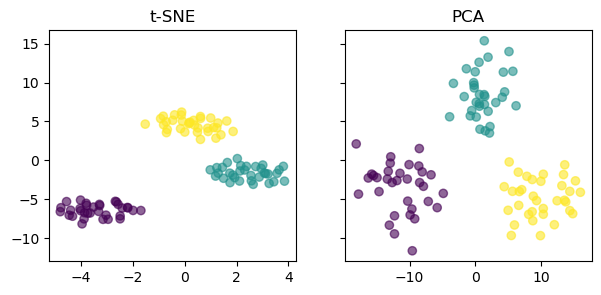

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Cluster the data in 3 groups
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X10d)

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
axs[1].set_title("PCA")
plt.show()

### Density based: DBSCAN

K-Means is an intuitive and effective algorithm, but what happens when the data has a complex shape?

As for the previous example, let's generate some synthetic data that resemble two half-moons.

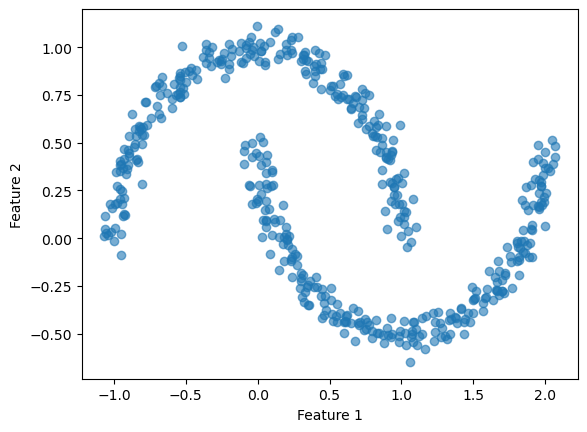

In [20]:
# Create 500 random points with 2-moons shape
X_moons, _ = make_moons(500, noise=0.05, random_state=0)

plt.scatter(X_moons[:,0], X_moons[:,1], alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

We can visually see that there are two groups. Let's assign the labels with K-Means!

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


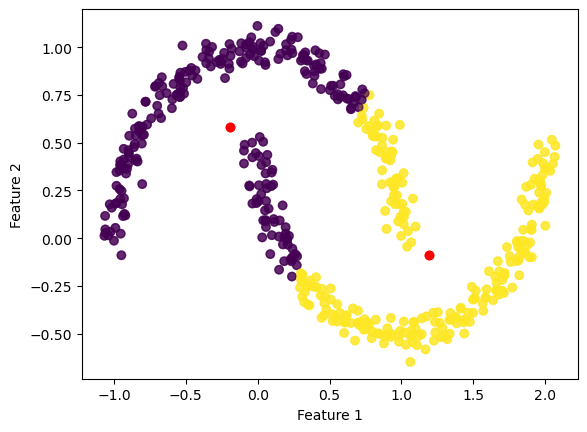

In [22]:
kmean = KMeans(n_clusters=2, random_state=0).fit(X_moons)
plt.scatter(X_moons[:,0], X_moons[:,1], c=kmean.labels_, alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Plot the centroids
for c in kmean.cluster_centers_:
    plt.scatter(c[0], c[1], marker="o", color="red")
plt.show()

Let's cluster the data with DBSCAN by variating the `eps` value in the range between 0.05 and 0.15.

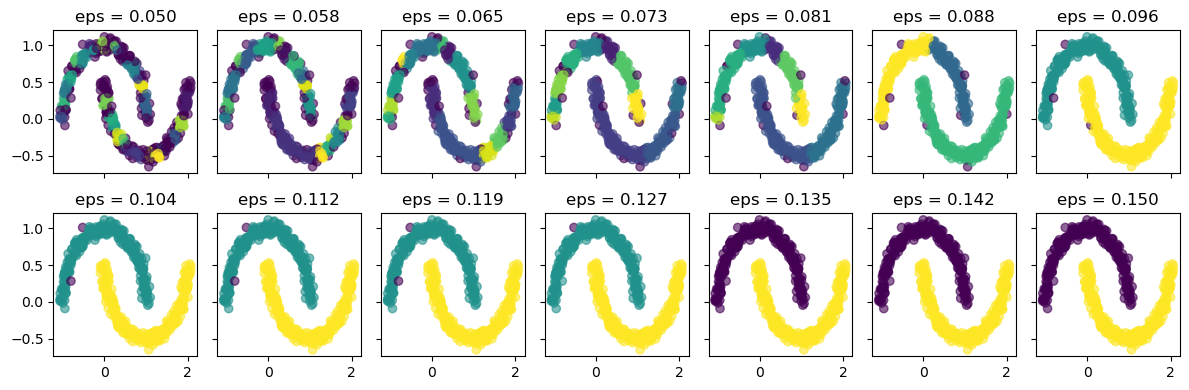

In [23]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]
    
    current_column = i%COLUMNS
    current_row = i//COLUMNS
    
    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(X_moons)
    ax.scatter(X_moons[:,0], X_moons[:,1], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))
    
plt.tight_layout()
plt.show()

-------
# Part B: Exercises

## Exercise 1. Real world data! Wheat has a kernel too!


<img src="img/wheat_banner.png" width="800">

Data Set Information:

> The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 70 elements each, randomly selected for
the experiment. High quality visualization of the internal kernel structure was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields, explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin.

Source: https://archive.ics.uci.edu/ml/datasets/seeds



In [55]:
seeds = pd.read_csv("seeds_dataset.csv")
seeds.head()

,ID,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove,seedType
0,1,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,2,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,3,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,4,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,5,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In this exercise, we are interested in discovering structure in the data by hiding the actual label provided in the dataset.

### Question 1.1: Prepare the dataset

- Create a dataset by keeping only the meaningful features. Remove the type.
- Plot the histogram of the different features.
- The features have different scales, but we want to give the same importance to all them. Find a way to mitigate the problem.

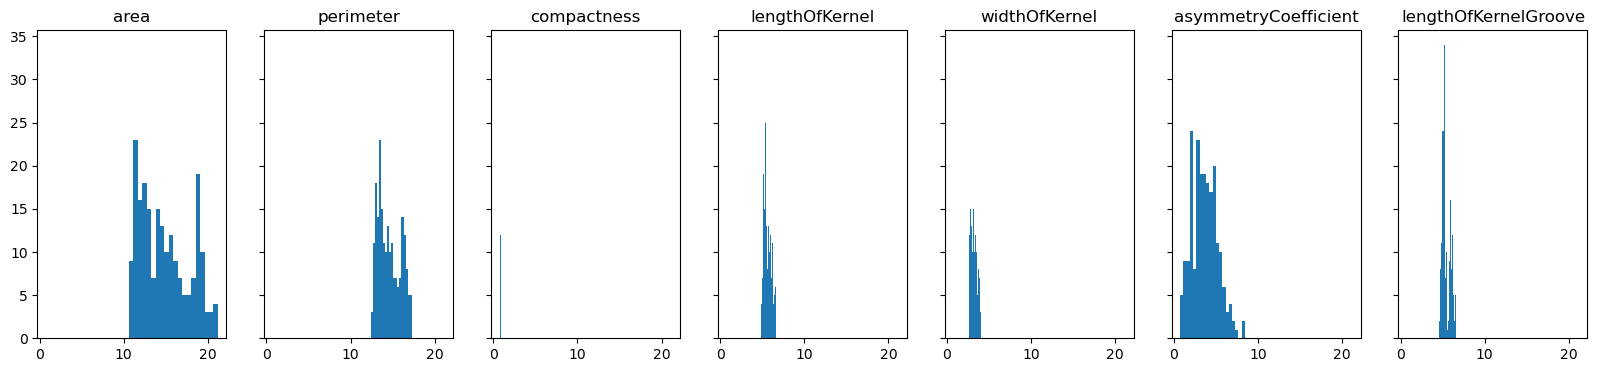

,area,perimeter,compactness,lengthOfKernel,widthOfKernel,asymmetryCoefficient,lengthOfKernelGroove
count,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02,2.100000e+02
mean,-3.214360e-16,1.015061e-16,1.150403e-15,-2.097793e-15,-3.045183e-16,-4.060244e-16,-9.304726e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.463218e+00,-1.645753e+00,-2.661876e+00,-1.646566e+00,-1.664233e+00,-1.952105e+00,-1.808966e+00
25%,-8.858385e-01,-8.494033e-01,-5.966534e-01,-8.267062e-01,-8.329169e-01,-7.573380e-01,-7.387301e-01
50%,-1.692697e-01,-1.832261e-01,1.037448e-01,-2.370616e-01,-5.719866e-02,-6.730769e-02,-3.765590e-01
75%,8.445808e-01,8.849547e-01,7.099807e-01,7.927006e-01,8.025778e-01,7.106807e-01,9.541143e-01
max,2.176333e+00,2.060336e+00,2.001803e+00,2.361889e+00,2.050213e+00,3.163032e+00,2.323446e+00


In [56]:
seeds.index = seeds["ID"]
seed_types = seeds["seedType"]
seeds = seeds.drop(columns=["ID", "seedType"])

fig, axs = plt.subplots(1, len(seeds.columns), figsize=(20,4), sharex=True, sharey=True)

for i, column in enumerate(seeds.columns):
    axs[i].hist(seeds[column], bins=20)
    axs[i].set_title(column)
plt.show()

for column in seeds.columns:
    seeds[column] = (seeds[column] - seeds[column].mean()) / seeds[column].std()


seeds.describe()

### Question 1.2: Cluster the data with K-Means

- Use the Elbow method to find the best value of K

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

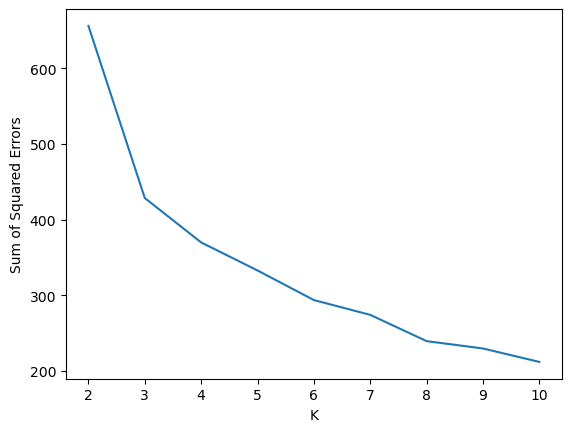

In [57]:
plot_sse(seeds)

### Question 1.3: Visualise your clusters

- Use t-SNE to plot your clusters
- Compare side by side 2 plots using the original labels (seedType) and the ones generated by K-Means.

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


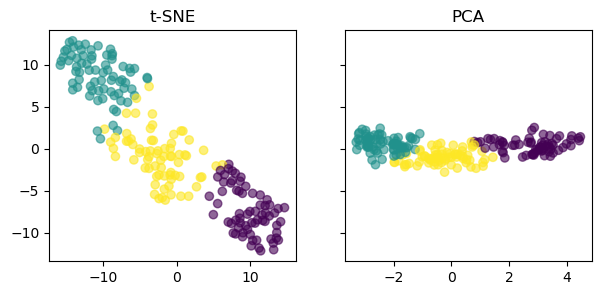

In [58]:
X_reduced_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(seeds)

X_reduced_pca = PCA(n_components=2).fit(seeds).transform(seeds)


fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

# Cluster the data in 3 groups
labels = KMeans(n_clusters=3, random_state=0).fit_predict(seeds)

# Plot the data reduced in 2d space with t-SNE
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[0].set_title("t-SNE")

# Plot the data reduced in 2d space with PCA
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
axs[1].set_title("PCA")
plt.show()

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


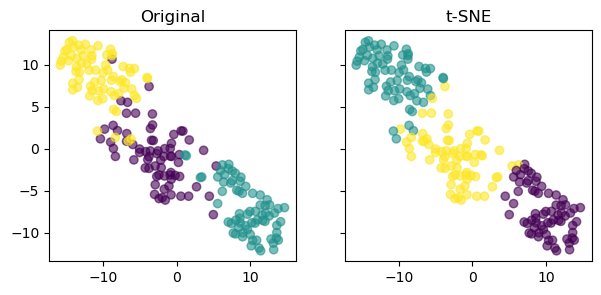

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

labels = KMeans(n_clusters=3, random_state=0).fit_predict(seeds)
axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
axs[1].set_title("t-SNE")

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=seed_types, alpha=0.6)
axs[0].set_title("Original")
plt.show()

# Exercise 2. Real world data! More examples with Wine

> These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

Source: https://archive.ics.uci.edu/ml/datasets/wine

### Question 2.1: Assign the wine to its group

In this dataset the label is missing. Repeat the previous analysis to assign the wine to its original group.

- Select the reasonable number of clusters
- Plot the data

In [62]:
wine = pd.read_csv("wine-clustering.csv")
wine.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [63]:
for column in wine.columns:
    wine[column] = (wine[column] - wine[column].mean()) / wine[column].std()
wine.describe()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
count,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,178.000000,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,1.780000e+02,178.000000
mean,-8.781989e-16,0.000000,-7.996101e-16,-7.983626e-17,1.995907e-17,0.000000,-3.193450e-16,3.592632e-16,-1.397135e-16,1.995907e-17,1.995907e-16,3.193450e-16,0.000000
std,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
min,-2.427388e+00,-1.428952,-3.668813e+00,-2.663505e+00,-2.082381e+00,-2.101318,-1.691200e+00,-1.862979e+00,-2.063214e+00,-1.629691e+00,-2.088840e+00,-1.889723e+00,-1.488987
25%,-7.860275e-01,-0.656896,-5.705131e-01,-6.871987e-01,-8.220960e-01,-0.882977,-8.252115e-01,-7.380592e-01,-5.956034e-01,-7.928659e-01,-7.654033e-01,-9.495697e-01,-0.782431
50%,6.082829e-02,-0.421922,-2.375431e-02,1.514024e-03,-1.219377e-01,0.095690,1.058511e-01,-1.755994e-01,-6.272092e-02,-1.587767e-01,3.303369e-02,2.370660e-01,-0.233063
75%,8.337767e-01,0.667909,6.961448e-01,6.003946e-01,5.082048e-01,0.806722,8.466967e-01,6.078267e-01,6.274055e-01,4.925666e-01,7.111583e-01,7.863692e-01,0.756117
max,2.253415e+00,3.100446,3.147447e+00,3.145637e+00,4.359076e+00,2.532372,3.054216e+00,2.395645e+00,3.475269e+00,3.425768e+00,3.292407e+00,1.955399e+00,2.963114


c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is k

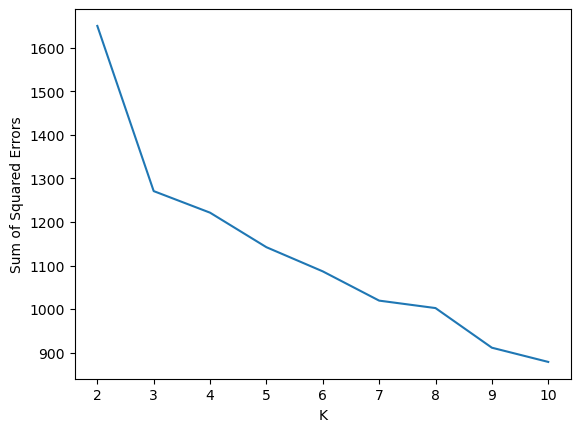

In [64]:
plot_sse(wine)

c:\Users\jerem\anaconda3\envs\ada\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


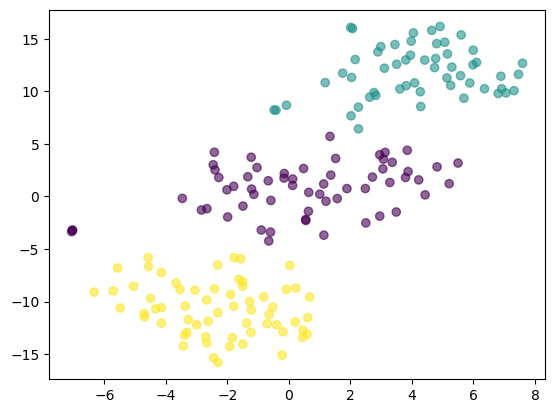

In [70]:
wine_tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=0).fit_transform(wine)

labels = KMeans(n_clusters=3, random_state=0).fit_predict(wine_tsne)

plt.scatter(wine_tsne[:,0], wine_tsne[:,1], c=labels, alpha=0.6)
plt.show()

---------
# Part C: Quiz

### Question 1: Which of the following real-world ML applications is not unsupervised learning?
1. Netflix matrix factorization pipeline to discover users with similar interests
2. Speaker recognition (recognition of the identity of who is talking) in phones and smart assistant devices
3. LDA topic modeling on Twitter content to discover customers' opinions about a product
4. K-means clustering of Web domains 


In [ ]:
2 askip

### Question 2: Which of the following is true for the k-means clustering algorithm?

1. It always converges to a global optimum.
2. In each iteration, points are assigned to the closest centroid and the new centroids are recomputed.
3. It outputs the optimal number of clusters.
4. None of the above.

In [ ]:
2